# Проект - Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:
- качество предсказания;
- скорость предсказания;
- время обучения.

**Инструкция по выполнению проекта**

- Для оценки качества моделей применяйте метрику RMSE.
- Значение метрики RMSE должно быть меньше 2500.
- Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
- Модель градиентного бустинга может долго обучаться, поэтому измените у неё только два-три параметра.

- Чтобы усилить исследование, не ограничивайтесь градиентным бустингом. Попробуйте более простые модели — иногда они работают лучше. Эти редкие случаи легко пропустить, если всегда применять только бустинг. 
- Поэкспериментируйте и сравните характеристики моделей: время обучения, время предсказания, точность результата.

**Основные шаги:**
1.  Загрузите данные, путь к файлу: /datasets/autos.csv. Изучите данные. Заполните пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалите их.
2.	Подготовьте выборки для обучения моделей.
3.	Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.
4.	Проанализируйте время обучения, время предсказания и качество моделей.
5.	Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.


**Признаки**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак - Price — цена (евро)


## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
pd.set_option('max_columns', None) # показывать все столбцы df
pd.set_option('max_rows', None) # показывать все строки df
pd.options.display.float_format = '{:,.2f}'.format  # округление чисел до 2 знаков после точки

In [2]:
try:
    data = pd.read_csv('/datasets/autos.csv')
except:
    data = pd.read_csv('autos.csv')

data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
data.tail()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


In [4]:
# общая информация по df
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
# сохранил в переменнной изначальный размер df
shape_data = data.shape
shape_data 

(354369, 16)

In [6]:
# выведем долю пропусков в признаках
data.isna().mean() * 100

DateCrawled          0.00
Price                0.00
VehicleType         10.58
RegistrationYear     0.00
Gearbox              5.60
Power                0.00
Model                5.56
Kilometer            0.00
RegistrationMonth    0.00
FuelType             9.28
Brand                0.00
Repaired            20.08
DateCreated          0.00
NumberOfPictures     0.00
PostalCode           0.00
LastSeen             0.00
dtype: float64

In [7]:
# выведем количество явных дубликатов
data.duplicated().sum()

4

In [9]:
data[data.duplicated(keep=False)].sort_values(by='RegistrationYear')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54


In [10]:
data = data.drop_duplicates().reset_index(drop=True)

In [11]:
# описательная статистика по df
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,"354,365.00","354,365.00","354,365.00","354,365.00","354,365.00","354,365.00","354,365.00"
mean,"4,416.68","2,004.23",110.09,"128,211.36",5.71,0.00,"50,508.50"
std,"4,514.18",90.23,189.85,"37,905.08",3.73,0.00,"25,783.10"
min,0.00,"1,000.00",0.00,"5,000.00",0.00,0.00,"1,067.00"
25%,"1,050.00","1,999.00",69.00,"125,000.00",3.00,0.00,"30,165.00"
50%,"2,700.00","2,003.00",105.00,"150,000.00",6.00,0.00,"49,413.00"
75%,"6,400.00","2,008.00",143.00,"150,000.00",9.00,0.00,"71,083.00"
max,"20,000.00","9,999.00","20,000.00","150,000.00",12.00,0.00,"99,998.00"


In [12]:
# корреляция данных
data.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.00,0.03,0.16,-0.33,0.11,NaN,0.08
RegistrationYear,0.03,1.00,-0.00,-0.05,-0.01,NaN,-0.00
Power,0.16,-0.00,1.00,0.02,0.04,NaN,0.02
Kilometer,-0.33,-0.05,0.02,1.00,0.01,NaN,-0.01
RegistrationMonth,0.11,-0.01,0.04,0.01,1.00,NaN,0.01
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.08,-0.00,0.02,-0.01,0.01,NaN,1.00


### удаление неинформативных признаков

In [13]:
# проверим значения в признаке NumberOfPictures  - все 0
data['NumberOfPictures'].value_counts()

0    354365
Name: NumberOfPictures, dtype: int64

**можно удалить признаки**
- дата создания, дата последнего просмотра (активности), дата скачивания анкеты, месяц регистрации, количество фотографий автомобиля, почтовый индекс владельца анкеты 
- эти данные могут повторяться (не уникальны) и бесполезны с точки зрения построения моделей машинного обучения

In [14]:
# удалим не информативные признаки, перед этим сохраним df в другой переменной
data_old = data.copy()
data = data.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], 
                 axis=1)
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


### обработка пропусков и аномалий

In [15]:
# выведем долю пропусков в признаках
data.isna().mean() * 100

Price               0.00
VehicleType        10.58
RegistrationYear    0.00
Gearbox             5.60
Power               0.00
Model               5.56
Kilometer           0.00
FuelType            9.28
Brand               0.00
Repaired           20.08
dtype: float64

In [16]:
# выведем уникальные значения признака 'Price'
data['Price'].value_counts().head()

0       10772
500      5670
1500     5394
1000     4648
1200     4594
Name: Price, dtype: int64

**удалим значения с нулевой ценой**

- yеобычные цены до 100-200 евро в данном случае оставим, т.к. из информации в df сложно понять причины таких цен. Ниже вывел ряд данных. Есть авто с низкой ценой и при этом не самые старые по году выпуска машины;
    
- могут быть разные варианты:
    - ошибка при загрузке данных 
    - битые или в плохом состояние машины на запчасти 
    
для решения нужна дополнительная информация от составителей базы данных.

In [17]:
# удалим значения с нулевой ценой
data = data[data['Price'] > 0]

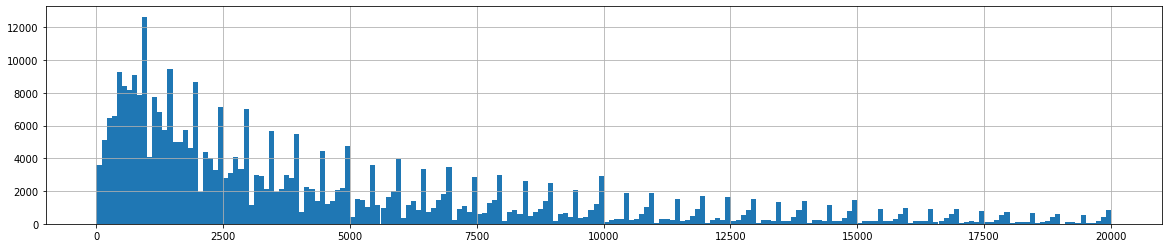

In [18]:
data['Price'].hist(bins=200, figsize=(20,4));

In [19]:
# количество авто с ценой меньше 100 евро
len(data[data['Price'] < 100])

2542

In [20]:
# количество авто с ценой меньше 200 евро
len(data[data['Price'] < 200])

6690

In [21]:
data[data['Price'] < 100].head(100)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
59,1,suv,1994,manual,286,NaN,150000,NaN,sonstige_autos,NaN
89,1,sedan,1995,manual,113,e_klasse,150000,gasoline,mercedes_benz,no
268,1,sedan,1990,manual,90,80,70000,petrol,audi,no
408,1,NaN,2000,NaN,75,golf,90000,petrol,volkswagen,NaN
552,50,NaN,1985,NaN,0,NaN,150000,NaN,trabant,NaN
901,1,NaN,1990,manual,0,other,150000,NaN,porsche,NaN
943,98,small,1997,manual,53,swift,150000,petrol,suzuki,no
967,1,wagon,1998,manual,136,omega,150000,petrol,opel,no
1025,3,convertible,1998,manual,110,mx_reihe,150000,NaN,mazda,yes
1076,45,NaN,2015,NaN,0,other,5000,NaN,mini,NaN


In [22]:
# выведем уникальные значения признака 'VehicleType'
data['VehicleType'].value_counts(dropna=False)

sedan          89405
small          78017
wagon          63700
NaN            33750
bus            28345
convertible    19865
coupe          15634
suv            11791
other           3086
Name: VehicleType, dtype: int64

In [23]:
# т.к. определить тип кузова по данным в df не возможно, заменим значение 'nan' на 'other'
data['VehicleType'] = data['VehicleType'].fillna('other')
data['VehicleType'].unique()

array(['other', 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon'], dtype=object)

In [24]:
# выведем уникальные значения признака 'RegistrationYear'
data['RegistrationYear'].sort_values().unique()

array([1000, 1001, 1039, 1111, 1234, 1255, 1300, 1400, 1500, 1600, 1602,
       1800, 1910, 1923, 1925, 1927, 1928, 1929, 1930, 1931, 1932, 1933,
       1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945,
       1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956,
       1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967,
       1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978,
       1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2066, 2200, 2222,
       2290, 2500, 2800, 2900, 3000, 3200, 3700, 3800, 4000, 4100, 4500,
       4800, 5000, 5300, 5555, 5600, 5900, 5911, 6000, 6500, 7000, 7100,
       7800, 8000, 8200, 8500, 8888, 9000, 9450, 9999])

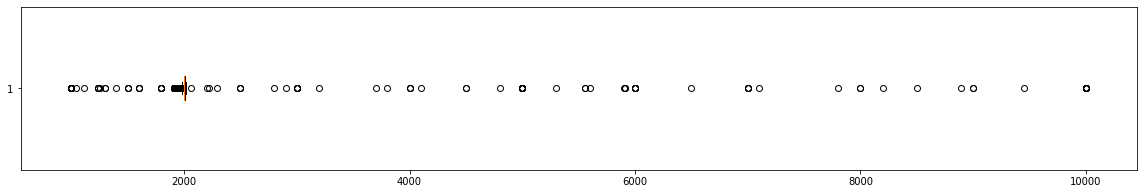

In [25]:
# также построим boxplot для признака 'RegistrationYear'
plt.figure(figsize=(20,3))
plt.boxplot(x = data['RegistrationYear'], vert=False)
plt.show()

In [26]:
# удалим значения признака год выпуска менее 1980 и старше 2023, т.к они скорее всего аномальные
data = data[(data['RegistrationYear'] >= 1980) & (data['RegistrationYear'] <= 2023)]
data['RegistrationYear'].sort_values().unique()

array([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018, 2019])

In [27]:
# уникальные значения признака 'DateCrawled'
data['DateCrawled'].sort_values().unique()

array(['2016-03-05 14:06:22', '2016-03-05 14:06:23',
       '2016-03-05 14:06:24', ..., '2016-04-07 14:36:55',
       '2016-04-07 14:36:56', '2016-04-07 14:36:58'], dtype=object)

In [28]:
# удалим значения признака год выпуска менее 1980 и более 2016 включительно, т.к они скорее всего аномальные
data = data[(data['RegistrationYear'] >= 1980) & (data['RegistrationYear'] <= 2016)]
data['RegistrationYear'].sort_values().unique()

array([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016])

In [29]:
# выведем уникальные значения признака 'Gearbox'
data['Gearbox'].value_counts(dropna=False)

manual    249217
auto       62377
NaN        15054
Name: Gearbox, dtype: int64

In [30]:
# т.к. определить тип трансмиссии по данным не возможно заменим значение 'nan' на 'unknown'
data['Gearbox'] = data['Gearbox'].fillna('unknown')
data['Gearbox'].unique()

array(['manual', 'auto', 'unknown'], dtype=object)

In [31]:
# также в признаке модель 'nan' на 'unknown'
data['Model'] = data['Model'].fillna('unknown')

<div class="alert alert-warning">
<b>Комментарий 👉</b>

По результатам проверки примерно 2,8 тысяч проектов за крайние 12 месяцев у меня родилось небольшое эссе на тему "удаления vs. спасения" данных, как раз на основе тех ситуаций и вопросов, которые мне коллеги задавали, которые мы обсуждали, уточняли и исправляли ... 

Желание уменьшить количество пропусков в данных (если такое желание конечно возникает ... но в рабочих проектах, "в жизни" оно как правило возникает) - можно только приветствовать. Приветствовать по 3-м минимум причинам:

1. это тренировка
    
2. это попытка сохранить данные ("данных много не бывает")
    
3. самое главное на мой взгляд - развитие аналитического мышления, желания "проникать" в секреты, которые скрывают данные. Когда вначале рождается гипотеза, потом эта гипотеза проверяется на данных (может ли такое быть? подтверждается?) и в финале уже гипотеза облекается в код.

Однако заполнение пропусков в данных не такая простая задача, как кажется ... простого ответа на вопросы: заполнять? удалить? чем заполнять? подходящего под все сценарии, нет ни в одной умной книжке ...

Самый идеальный случай - когда у тебя под рукой есть эксперт в предметной области. Если такой есть - советуйся с ним. Как правило это человек из бизнеса, который знает суть бизнес-процесса и вот именно он даст тебе точный и аргументированный совет - что в данной, конкретной задаче делать с "битыми" полями в строках датафрейма. Ты скажешь ему какой процент пропусков в данных, а он тебе ответит что делать: можно/нельзя удалить и/или даст рекомендации по заполнению. Вообще, как правило такой человек "на любой работе" есть. Для примера, финансовый директор думаю всегда даст рекомендации по финансовым данным, прочие профильные спецы - по своей сфере компетенций. Наверное только в зарождающемся стартапе может не быть каких-то компетенций, но тут уже можно и через фриланс (и т.п.) попробовать найти спеца и просить совета.

Теперь, что делать, если такого человека нет. Я бы ответил так: **ПОПЫТАТЬСЯ** вникнуть в бизнес-проблему самому. Наверное это сложно, если предметная область ну совсем незнакома. Но в общем случае, если бизнес совсем незнаком, то заполнение пропусков в данных наверное, не получиться. В таком случае попробуй ориентироваться на такое правило: если записи с пропусками в ключевых для твоего анализа столбцах составляют 1-3-5-ну может до 10% строк, то попробуй эти записи из оригинального датафрейма вырезать (но сохрани бы в некий df, к которому ты при необходимости можешь всегда обратиться).

В жизни, МНЕ КАЖЕТСЯ, как правило по всему датафрейму заполнять медианой/средним - ну вообще не вариант. Почему? Я бы ответил так - потому, что реальные датафреймы имеют миллионы строк и горизонт в несколько (десятков) лет, и если в 90-2000-е года всё было как-то более -менее стабильно/прогнозируемо, то в нынешней реальности события раскручиваются гораздо быстрее и не прогнозируемо. Пример: ты аналитик в автобизнесе. У тебя есть данные с пропусками в цене для машин в 2005-2007 года. Можно заполнить их средними основываясь на данных 2020-2021?

Может быть и такой вариант, что без заполнения некоторых столбцов некоторые записи по сути **НЕ** имеют смысла, но если их (записи с пропусками удалить), то и данных-то не останется. Ну тогда я бы такой совет дал - всё же заполнять медианой (она к скачкам выбросов более устойчива), но не по всему глобальному датафрейму, а выбрать простые группы (например, группы по интервалу лет - чтобы сгладить турбулентность нынешних лет) или выбрать более сложные группы (например, группы по интервалу лет и одновременно марке автопроизводителя (это я про вымышленный пример с автобизнесом)).

Теперь предположим, что мы выбрали какую-то стратегию заполнения "пропусков", не суть какую (оставить NaN или заполнить "заглушкой"). И в том и в другом случае придётся помнить этот выбор. Ты спросишь почему? Отвечу - потому, что инструменты, применяемые тобой в Питон/Пандас в каких-то случаях могут спокойно пропускать твой выбор, а в каких-то случаях тебе придется этот твой выбор обрабатывать.

Пример 1: мы заполнили пропуски "заглушкой". В этом случае: 1. расчет корреляций значение "заглушку" будет "ловить" (надо отфильтровать!), 2. расчет гипотез также будет "сбивать" правильный вывод (надо отфильтровать!) 3. графики, которые ты будешь строить - будут "заглушку" отображать на осях (нужно фильтровать), 4. в группировках также по-видимому "заглушку" надо будет убирать.

Пример 2: мы оставили пропуски как NaN. В этом случае: 1. метод .corr NaN'ы пропускает (отфильтровать не надо), 2. в расчет гипотез всё равно пропуски отфильтровать 3. графики, которые ты будешь строить могут отображать, а могут не отображать, 4. в группировках NaN'ы по sum() видны не будут, а по count() будут.

Ну и напоследок совсем уже жёсткий пример: додумывать "от себя", бездумно проставлять в пропуски медианные/средние значения - это НЕ верно. Давай же опять "про жизнь". Я писал выше, что в медицине работаю, да? **Предположим** мне принесли данные из онкологического диспансера. Задача: построить модель, которая по некоторым маркерным анализам будет прогнозировать наличие онкологии. **По-простому, ответить, что стоит за строчкой в данных: жизнь или смерть.** Уууууух … аж мороз по коже продирает, правда? 

Итак, 1.000.000 записей и 70 столбцов. Данные за 25 лет. 70 столбцов - это поля, с результатами конкретных и очень специфичных анализов. В "начале" данных, 15-20 лет назад, есть пропуски (много), но и в принципе, в данных есть пропуски. Как думаешь - имею я моральное право перед людьми, которые фактически доверяют мне в виде данных свою жизнь огульно подойти к заполнению пропусков?
</div>

In [32]:
# выведем уникальные значения признака 'Power', первые 200
data['Power'].sort_values().unique()[:200]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [33]:
# выведем количество уникальных значений признака 'Power', первые 10 
data['Power'].value_counts(dropna=False).head(10)

0      31968
75     22073
60     14671
150    13710
101    12394
140    12328
90     11689
116    11374
105     9844
170     9671
Name: Power, dtype: int64

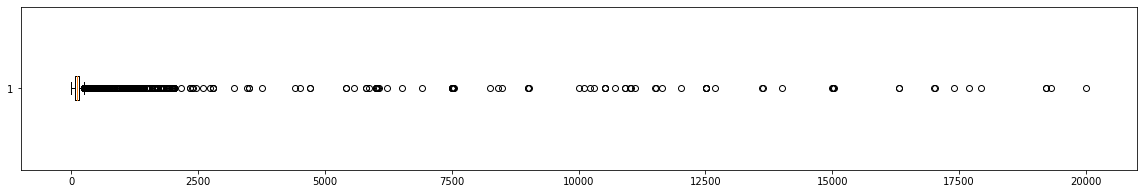

In [34]:
# построим boxplot и гистограмму для признака 'Power'
plt.figure(figsize=(20,3))
plt.boxplot(x = data['Power'], vert=False)
plt.show()

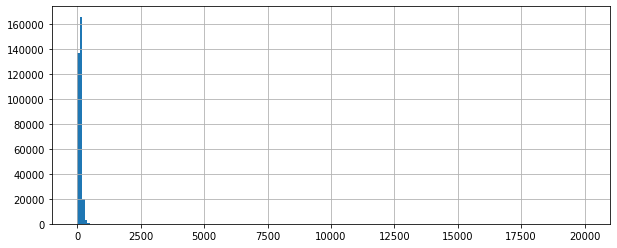

In [35]:
data['Power'].hist(bins=200, figsize=(10,4));

**удалим значения признака мощность ('Power') более 1000, т.к они скорее всего аномальные 
и заменим значения от 0 до 50 на медианные** 

- Верхний порог мощности в 1000 определял а) из общей информации по рынку - подавляющее большинство авто в РФ с мощностью 90-120 л.с. и менее 50 л.с. современных машин в массовом сегементе нет б) из данных распределения в данном df

- "Средняя мощность автомобилей в России составляет 117 лошадиных сил. Такой вывод сделали эксперты портала Auto.ru, проанализировав данные о парке машин в стране." https://rg.ru/2019/10/18/reg-skfo/eksperty-nazvali-sredniuiu-moshchnost-avtomobilej-v-rossii.html

In [36]:
data = data[(data['Power'] <= 1000)]
power_median = data['Power'].median()
power_false = [i for i in range(50)]
data['Power'] = data['Power'].replace(power_false, power_median)

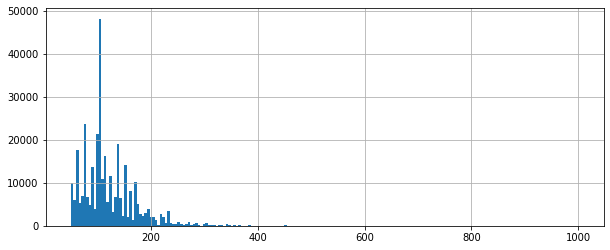

In [37]:
# посмотрим распредление признака мощность - оно стало более реальным, основные значения мощности 50-200 л.с.
data['Power'].hist(bins=200, figsize=(10,4));

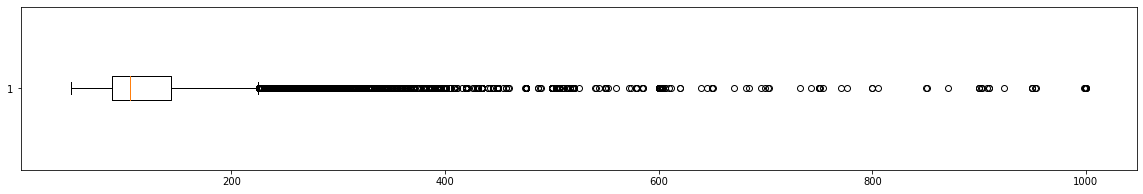

In [38]:
plt.figure(figsize=(20,3))
plt.boxplot(x = data['Power'], vert=False)
plt.show()

In [39]:
# выведем уникальные значения признака 'FuelType'
data['FuelType'].value_counts(dropna=False)

petrol      202175
gasoline     94660
NaN          23584
lpg           5000
cng            528
hybrid         220
other          137
electric        86
Name: FuelType, dtype: int64

In [40]:
# в признаке топливо заменим gasoline на petrol т.к. это одинаковое обозначение бензина и 'nan' на 'unknow'
data['FuelType'] = data['FuelType'].replace('gasoline', 'petrol')
data['FuelType'] = data['FuelType'].fillna('unknown')

In [41]:
# выведем уникальные значения признака 'Repaired'
data['Repaired'].value_counts(dropna=False)

no     234838
NaN     58904
yes     32648
Name: Repaired, dtype: int64

In [42]:
# в признаке после ремонта заменим 'nan' на 'unknow'
data['Repaired'] = data['Repaired'].fillna('unknown')

In [43]:
# выведем информацию по измененому df
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326390 entries, 0 to 354364
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             326390 non-null  int64  
 1   VehicleType       326390 non-null  object 
 2   RegistrationYear  326390 non-null  int64  
 3   Gearbox           326390 non-null  object 
 4   Power             326390 non-null  float64
 5   Model             326390 non-null  object 
 6   Kilometer         326390 non-null  int64  
 7   FuelType          326390 non-null  object 
 8   Brand             326390 non-null  object 
 9   Repaired          326390 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 27.4+ MB


In [44]:
# количнство дубликатов по измененому df
data.duplicated().sum()

43495

In [45]:
data[data.duplicated(keep=False)].sort_values(by='Power').head(100)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
20161,550,small,1998,manual,50.00,polo,150000,petrol,volkswagen,unknown
87315,1000,small,2000,manual,50.00,polo,150000,petrol,volkswagen,no
209210,999,small,1999,manual,50.00,lupo,150000,petrol,volkswagen,no
180814,300,other,2016,manual,50.00,polo,150000,petrol,volkswagen,unknown
12978,1250,small,2000,manual,50.00,lupo,150000,petrol,volkswagen,no
240761,1299,small,2001,manual,50.00,polo,150000,petrol,volkswagen,no
188910,1150,small,1997,manual,50.00,polo,125000,petrol,volkswagen,no
240843,890,small,1999,manual,50.00,lupo,150000,petrol,volkswagen,no
188915,750,small,1998,manual,50.00,ka,80000,petrol,ford,no
180764,1150,small,1999,manual,50.00,lupo,150000,petrol,volkswagen,no


In [46]:
# удалим дубликаты
data_2 = data.drop_duplicates().reset_index(drop=True)

In [47]:
# размер df после обработки
data_2.shape

(282895, 10)

In [48]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,other,1993,manual,105.00,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190.00,unknown,125000,petrol,audi,yes
2,9800,suv,2004,auto,163.00,grand,125000,petrol,jeep,unknown
3,1500,small,2001,manual,75.00,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69.00,fabia,90000,petrol,skoda,no


In [49]:
data.tail()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
354359,1150,bus,2000,manual,105.00,zafira,150000,petrol,opel,no
354361,2200,other,2005,unknown,105.00,unknown,20000,unknown,sonstige_autos,unknown
354362,1199,convertible,2000,auto,101.00,fortwo,125000,petrol,smart,no
354363,9200,bus,1996,manual,102.00,transporter,150000,petrol,volkswagen,no
354364,3400,wagon,2002,manual,100.00,golf,150000,petrol,volkswagen,unknown


<div class="alert alert-warning">
<b>Комментарий 👉</b>

Несколько моментов "на будущее" (сейчас забегаю чуть вперед, но будущем это будет важно) которые я хотел озвучить перед переходом к собственно исследованию (некоторые из этих моментов в твоем проекте реализованы):
    
- имеет смысл критично посмотреть на данные с точки зрения наличия пропусков в признаках (вопрос: все ли ml-модели "любят" пропуски?) и обработать или удалить их 
    
- имеет смысл явно обозначить какую задачу мы будем решать: с учителем / без учителя, классификации / регрессии ...
    
- в моделях бинарной классификации (если бы это был бы наш случай!) имеет смысл смотреть на баланс классов. Два взгляда (с разных сторон) на эту проблему тут: https://alexanderdyakonov.wordpress.com/2021/05/27/imbalance/ и https://habr.com/ru/post/349078/
    
- имеет смысл смотреть на корреляцию признаков. При высокой их степени коррелированности возникает проблема  мультиколлиниарность признаков. Проблема "мультиколлинеарности" это и про переобучение модели и про её интерпретируемость и про сложность модели (содержание в модели избыточного количества переменных). В чем негативный эффект сложной модели? Вот в чем: усложняется интерпретация параметров, оценки параметров ненадежны – получаются большие стандартные ошибки, которые меняются с изменением объема наблюдений, что делает модель регрессии непригодной для прогнозирования.

Вот несколько причин, почему проблема мультиколлинеарности (МК) важна:

1. Неоднозначность коэффициентов: МК делает оценку коэффициентов модели неустойчивой. Когда существует сильная корреляция между признаками, модель становится неспособной разделить влияние каждого признака на целевую переменную. Это может привести к неоднозначным и неправильным оценкам коэффициентов, что затрудняет интерпретацию важности каждого признака. Согласись - это важно, чтобы результат, который выдает модель можно было бы понять и объяснить с точки зрения предметной области. В случае включения в модель высокоскоррелированных признаков - может случиться так, что коэффициенты (да, проблема присуща моделям линейным ... регрессия среди них!) могут менять знаки и попытка объяснения предметной области с помощью этих коэффициентов будет противоречить здравому смыслу.

2. Плохая обобщающая способность: МК может снизить способность модели обобщаться на новые данные. Когда сильно коррелированные признаки присутствуют в модели, модель может стать "перегенерированной" и склонной к переобучению на обучающих данных. В результате модель может показывать хорошую производительность на обучающих данных, но плохо обобщаться на новые данные.

3. Ухудшение точности и устойчивости модели: МК может привести к численным проблемам при решении линейных уравнений, используемых для оценки коэффициентов модели. Это может привести к нестабильности и неточности оценок. Кроме того, небольшие изменения в данных могут привести к большим изменениям в оценках коэффициентов модели, что делает модель неустойчивой.

4. Избыточность информации: Когда признаки сильно коррелированы, они предоставляют практически одинаковую информацию о целевой переменной. Такая избыточность может привести к неэффективности модели и увеличению сложности модели без значительного улучшения производительности.

В целом, МК может иметь отрицательное влияние на производительность, стабильность, интерпретируемость и обобщающую способность.
    
---
Для деревянных моделей и моделей градиентного бустинга проблема МК  не является такой критической, как для линейных моделей. Вот несколько причин:

1. Нелинейность: Деревянные модели и модели градиентного бустинга являются нелинейными моделями. Они способны обрабатывать сложные взаимодействия между признаками и целевой переменной. В отличие от линейных моделей, они могут более гибко адаптироваться к наличию мультиколлинеарности в данных.

2. Рекурсивное разбиение: Деревья принятия решений в деревянных моделях и моделях градиентного бустинга используют рекурсивное разбиение для разделения данных на более чистые группы. Это означает, что деревья могут независимо выбирать разные признаки для разделения, даже если они сильно коррелированы. Таким образом, деревья могут игнорировать мультиколлинеарность и использовать другие признаки для принятия решений.

3. Ансамбль деревьев: Модели градиентного бустинга строятся на основе ансамбля слабых деревьев решений. Каждое дерево добавляется постепенно для уменьшения ошибки предыдущих деревьев. Это позволяет модели градиентного бустинга восстанавливать ошибки, вызванные мультиколлинеарностью, поэтапно улучшая прогнозы.

Хотя мультиколлинеарность не является проблемой в деревянных моделях и моделях градиентного бустинга в той же степени, что и в линейных моделях, она все еще может оказывать влияние на производительность и интерпретируемость модели. Сильно коррелированные признаки могут вносить избыточность в модель и увеличивать сложность, не принося значительного улучшения в прогнозах. Поэтому, хотя деревья могут быть более устойчивыми к мультиколлинеарности, все же рекомендуется выполнять анализ корреляции признаков и, при необходимости, применять методы снижения размерности или регуляризации для улучшения модели.
    
Вот классная статья. Простым языком, на примере показана проблема. А также, что важно - разобраны варианты как её (проблему) победить. Статья: https://habr.com/ru/company/akbarsdigital/blog/592493/ 
</div>

## 2.Подготовка данных 

**переведем признаки с типом данных в object в категориальные данные с кодированием** 

In [50]:
for i in data.columns:
   col_type = data[i].dtype
   if col_type == 'object':
      data[i] = data[i].astype('category').cat.codes

**разделим выборку train и test**

In [51]:
# разделим данные на выборки: признаки, целевой признак
features = data.drop('Price', axis=1)
target = data['Price']

# разделим на обучающую и тестовую выборки в пропорции 4 к 1
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=12345)

# разделим на обучающую выборку на обучающую и тестовую в пропорции 3 к 1
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=12345)

In [52]:
# данные о размере выборок
print('размеры выборок на train: ', X_train.shape, y_train.shape) 
print('размеры выборок на valid: ', X_valid.shape, y_valid.shape) 
print('размеры выборок на test: ', X_test.shape, y_test.shape) 

размеры выборок на train:  (195834, 9) (195834,)
размеры выборок на valid:  (65278, 9) (65278,)
размеры выборок на test:  (65278, 9) (65278,)


**масштабируем признаки**

In [53]:
# инициализируем и обучим scaler 
numeric = ['RegistrationYear', 'Power', 'Kilometer']
scaler = StandardScaler()
scaler.fit(X_train[numeric]) 

StandardScaler()

In [54]:
# преобразуем выборки функцией transform()
X_train[numeric] = scaler.transform(X_train[numeric])
X_valid[numeric] = scaler.transform(X_valid[numeric])
X_test[numeric] = scaler.transform(X_test[numeric]) 
pd.options.mode.chained_assignment = None

/tmp/ipykernel_48/3613493287.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[numeric] = scaler.transform(X_test[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [55]:
X_train.head(5)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
254570,5,-0.82,2,-0.30,166,-0.10,6,31,1
127182,6,0.84,1,0.38,170,0.58,5,38,0
288247,4,-1.31,1,-0.59,154,-0.10,5,10,0
154394,7,-0.98,1,-0.20,170,0.58,5,38,0
322449,4,-1.64,1,-0.59,116,0.58,5,38,2


**Выводы, Информация п.1,2**
1. Загружены, изучены данные, информация по df:
    - 354 369 строк,  16 столбцов.
    - есть пропущеные данные
2. Удалены не информативные признаки;
3. Обработаны пропущеные и аномальные значения;
4. Кодированны категориальные данные;
5. Выборка разделена на выборки train и test
6. Масштабированы признаки методом StandardScaler()

Итоговый DataFrame с учетом оптимизации аномальных значений и не инфоративных признаков = 326 380 строк,  9 столбцов.
- размеры выборок на train:  (195834, 9) (195834,)
- размеры выборок на valid:  (65278, 9) (65278,)
- размеры выборок на test:  (65278, 9) (65278,)

В итоге:
- изначальный df = 354 369 строк
- изменененый df = 326 380 строк
- удалено из df 27 989 - 7.9%

Далее решаем задачу регресии, обучение c учителем (предсказание цены авто).
Делаем обучения на моделях бустинга и линейной регрессии, проверяем качество обучения и скорость работы

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Вот пример ЧЕРНОВИКА шаблона пайплайна обработки данных для машинного обучения, включающий деление данных на выборки, кодирование категориальных переменных и масштабирование числовых переменных:
    
    from sklearn.model_selection import train_test_split
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler, OneHotEncoder

    # 1. Загрузка и подготовка данных
    # Загрузка данных
    data = ...

    # Разделение на признаки (X) и целевую переменную (y)
    X = data.drop(columns=['target'])
    y = data['target']

    # 2. Разделение данных на обучающую, валидационную и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # 3. Создание пайплайна обработки данных
    # Предобработка числовых переменных
    numeric_features = [...]  # список числовых переменных

    numeric_transformer = StandardScaler()

    # Предобработка категориальных переменных
    categorical_features = [...]  # список категориальных переменных

    categorical_transformer = OneHotEncoder()

    # Комбинированный препроцессор для числовых и категориальных переменных
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # 4. Создание пайплайна для обучения модели
    from sklearn.linear_model import LinearRegression

    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', LinearRegression())])

    # 5. Обучение модели
    model.fit(X_train, y_train)

    # 6. Оценка модели
    train_score = model.score(X_train, y_train)
    val_score = model.score(X_val, y_val)
    test_score = model.score(X_test, y_test)

    # Вывод результатов
    print('Train Score:', train_score)
    print('Validation Score:', val_score)
    print('Test Score:', test_score)
    
    
В данном примере:

Шаг 1: Загружаются и подготавливаются данные.
    
Шаг 2: Данные разделяются на обучающую, валидационную и тестовую выборки с помощью функции train_test_split().
    
Шаг 3: Создается пайплайн обработки данных с использованием ColumnTransformer, который применяет соответствующие преобразования к числовым и категориальным переменным.
    
Шаг 4: Создается пайплайн для обучения модели, включающий предобработку данных и модель.
    
Шаг 5: Модель обучается на обучающих данных с помощью метода fit().
    
Шаг 6: Оценивается производительность модели на обучающей, валидационной и тестовой выборках с помощью метода score().    
</div>

**проверим корреляцию на измененных данных**

In [56]:
# по этим данным четко видно, target коррелирет наиболее сильно с 'RegistrationYear', 'Power', 'Kilometer', 'Repaired'
data.corr()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
Price,1.00,-0.06,0.54,-0.27,0.49,-0.05,-0.36,-0.08,-0.11,-0.28
VehicleType,-0.06,1.00,0.00,-0.06,-0.01,-0.14,0.04,-0.02,-0.05,0.00
RegistrationYear,0.54,0.00,1.00,-0.05,0.12,-0.02,-0.32,-0.02,-0.02,-0.15
Gearbox,-0.27,-0.06,-0.05,1.00,-0.38,0.07,-0.03,0.14,0.11,0.10
Power,0.49,-0.01,0.12,-0.38,1.00,-0.12,0.09,-0.07,-0.30,-0.08
Model,-0.05,-0.14,-0.02,0.07,-0.12,1.00,-0.03,0.04,0.44,0.05
Kilometer,-0.36,0.04,-0.32,-0.03,0.09,-0.03,1.00,-0.02,-0.05,0.09
FuelType,-0.08,-0.02,-0.02,0.14,-0.07,0.04,-0.02,1.00,0.02,0.10
Brand,-0.11,-0.05,-0.02,0.11,-0.30,0.44,-0.05,0.02,1.00,0.01
Repaired,-0.28,0.00,-0.15,0.10,-0.08,0.05,0.09,0.10,0.01,1.00


## 4.Обучение моделей

### lightgbm

In [57]:
print(lgb.__version__)

3.3.1


провел изучени модели lightgbm, источники:
-    https://lightgbm.readthedocs.io/en/latest/index.html
-    https://pythonru.com/biblioteki/lightgbm
-    https://habr.com/ru/companies/skillfactory/articles/530594/

**комментари по  lightgbm**

- в params вывел параметры, в том числе которые со значениями по умолчанию, для изучения

- по ошибке 'verbose_eval' пишет, что нужно использовать параметр calback и передать 
ему список функций, которые ответчают за вывод запись Логов. Често пытался разобраться, смотрел в трех источниках в том числе 
в первоисточнике - как передать функции разобрался, но как вывести Логи нет. М.б. ты знаешь. Если да напиши пжл или м.б. 
есть статья хорошая по  этой теме. Хочется разобраться.
    
"verbose_eval - почему-то выдает ошибку: "/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.""

параметр   - callbacks=[lgb.log_evaluation(10), lgb.record_evaluation({'metric':'rmse'})]

**модель lightgbm_1 с числом деревьев в ансамбле = 100**

In [68]:
start_time = time.time()

params = {
    'boosting': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'force_row_wise':True,
    'n_jobs': -1
}

model_lgb_1 = lgb.train(params, lgb.Dataset(X_train, y_train), num_boost_round=100, verbose_eval=10,
                                callbacks=[lgb.log_evaluation(10), lgb.record_evaluation({'metric':'rmse'})])

end_time = time.time()
training_time_lgb_1 = end_time - start_time

# время обучения модели lightgbm_1
print(f'Время обучения lightgbm_1: {training_time_lgb_1:.2f} секунд')

# время предсказания модели lightgbm_1 на валидационной выборке
start_time = time.time()
predict_lgb_1 = model_lgb_1.predict(X_valid)
end_time = time.time()
prediction_time_lgb_1 = end_time - start_time
print(f'Время предсказания lightgbm_1: {prediction_time_lgb_1:.2f} секунд')

# оценка качества модели lightgbm на валидационной выборке
rmse_lgb_1 = mean_squared_error(y_valid, predict_lgb_1, squared=False)
print(f'RMSE lightgbm_1 на валидационной выборке: {rmse_lgb_1:.2f}')

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.276045
[LightGBM] [Info] Total Bins 610
[LightGBM] [Info] Number of data points in the train set: 195834, number of used features: 9
[LightGBM] [Info] Start training from score 4579.399915
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained

**модель lightgbm_2 с числом деревьев в ансамбле = 500**

In [59]:
start_time = time.time()

params = {
    'boosting': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'force_row_wise':True,
    'n_jobs': -1
}

model_lgb_2 = lgb.train(params, lgb.Dataset(X_train, y_train), num_boost_round=500)

end_time = time.time()
training_time_lgb_2 = end_time - start_time

# время обучения модели lightgbm_2
print(f'Время обучения lightgbm_2: {training_time_lgb_2:.2f} секунд')

# время предсказания модели lightgbm_2 на валидационной выборке
start_time = time.time()
predict_lgb_2 = model_lgb_2.predict(X_valid)
end_time = time.time()
prediction_time_lgb_2 = end_time - start_time
print(f'Время предсказания lightgbm_2: {prediction_time_lgb_2:.2f} секунд')

# оценка качества модели lightgbm_2 на валидационной выборке
rmse_lgb_2 = mean_squared_error(y_valid, predict_lgb_2, squared=False)
print(f'RMSE lightgbm_3 на валидационной выборке: {rmse_lgb_2:.2f}')

[LightGBM] [Info] Total Bins 610
[LightGBM] [Info] Number of data points in the train set: 195834, number of used features: 9
[LightGBM] [Info] Start training from score 4579.399915
Время обучения lightgbm_2: 19.40 секунд
Время предсказания lightgbm_2: 1.80 секунд
RMSE lightgbm_3 на валидационной выборке: 1578.10


**модель lightgbm_3 с числом деревьев в ансамбле = 1000**

In [60]:
start_time = time.time()

params = {
    'boosting': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'force_row_wise':True,
    'n_jobs': -1
}

model_lgb_3 = lgb.train(params, lgb.Dataset(X_train, y_train), num_boost_round=1000)

end_time = time.time()
training_time_lgb_3 = end_time - start_time

# время обучения модели lightgbm_3
print(f'Время обучения lightgbm_3: {training_time_lgb_3:.2f} секунд')

# время предсказания модели lightgbm_3 на валидационной выборке
start_time = time.time()

predict_lgb_3 = model_lgb_3.predict(X_valid)
end_time = time.time()
prediction_time_lgb_3 = end_time - start_time
print(f'Время предсказания lightgbm_3: {prediction_time_lgb_3:.2f} секунд')

# оценка качества модели lightgbm_3 на валидационной выборке
rmse_lgb_3 = mean_squared_error(y_valid, predict_lgb_3, squared=False)
print(f'RMSE lightgbm_3 на валидационной выборке: {rmse_lgb_3:.2f}')

[LightGBM] [Info] Total Bins 610
[LightGBM] [Info] Number of data points in the train set: 195834, number of used features: 9
[LightGBM] [Info] Start training from score 4579.399915
Время обучения lightgbm_3: 43.39 секунд
Время предсказания lightgbm_3: 4.51 секунд
RMSE lightgbm_3 на валидационной выборке: 1545.20


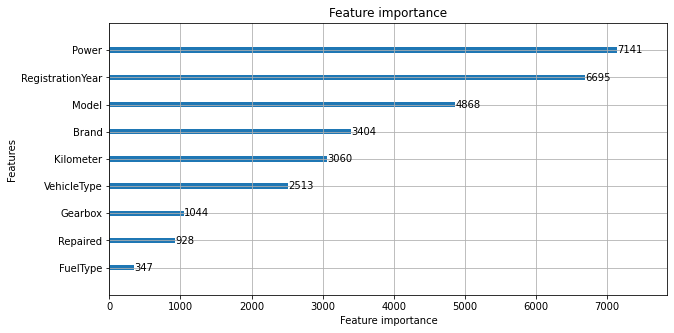

In [61]:
lgb.plot_importance(model_lgb_3, figsize=(10,5));

<div class="alert alert-success">
<b>ОТЛИЧНО!</b>

про визуализацию признаков, которые модель "посчитала" важными. Почему их анализ важен и полезен (несколько причин, почему важно тщательно "рассматривать" признаки:

1. **Информативность**: Признаки содержат информацию, которая помогает модели делать предсказания. Некоторые признаки могут быть более информативными, чем другие, и могут иметь сильное влияние на результаты модели. Понимание, какие признаки являются наиболее информативными, поможет сосредоточить усилия на сборе и анализе этих признаков, что в конечном итоге может привести к лучшим предсказаниям модели.

2. **Устранение шума и избыточности**: Некоторые признаки могут содержать шумовую или избыточную информацию, которая может негативно повлиять на работу модели. Анализ и отсев таких признаков помогут улучшить качество модели, устранить возможное переобучение и улучшить ее способность обобщать данные.

3. **Раскрытие взаимосвязей**: Изучение признаков может помочь обнаружить скрытые взаимосвязи и зависимости в данных. Например, два признака могут быть слабо информативными сами по себе, но в комбинации могут образовывать сильный предиктор. Исследование и понимание взаимосвязей между признаками может привести к созданию более сложных, но более мощных моделей.

4. **Сокращение размерности**: Некоторые наборы данных могут содержать большое количество признаков, и это может стать проблемой для обучения моделей. Сокращение размерности путем отбора наиболее важных признаков позволяет сократить вычислительную сложность, снизить вероятность переобучения и улучшить интерпретируемость модели.

5. **Интерпретируемость**: Понимание важности признаков также помогает интерпретировать результаты модели. Если мы знаем, какие признаки оказывают наибольшее влияние на предсказания, мы можем сделать более осознанные выводы и принимать меры на основе результатов   
</div>


**модель CatBoostRegressor**

In [62]:
start_time = time.time()

model_catboost = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=10, loss_function='RMSE', 
                                   random_state=12345)
model_catboost.fit(X_train, y_train, verbose=100)

end_time = time.time()
training_time_cbr = end_time - start_time

# время обучения модели CatBoostRegressor
print(f'время обучения CatBoostRegressor: {training_time_cbr:.2f} секунд')

# Время предсказания модели CatBoostRegressor на валидационной выборке
start_time = time.time()
predict_catboost = model_catboost.predict(X_valid)
end_time = time.time()
prediction_time_cbr = end_time - start_time
print(f'время предсказания CatBoostRegressor: {prediction_time_cbr:.2f} секунд')

# Оценка качества модели CatBoostRegressor на валидационной выборке
rmse_catboost = mean_squared_error(y_valid, predict_catboost, squared=False)
print(f'RMSE CatBoostRegressor на валидационной выборке: {rmse_catboost:.2f}')

0:	learn: 4206.5801190	total: 98.5ms	remaining: 1m 38s
100:	learn: 1662.7906662	total: 4.77s	remaining: 42.4s
200:	learn: 1565.0033117	total: 9.58s	remaining: 38.1s
300:	learn: 1509.5934381	total: 14.4s	remaining: 33.4s
400:	learn: 1466.7101026	total: 19.2s	remaining: 28.7s
500:	learn: 1434.2491428	total: 24.2s	remaining: 24.2s
600:	learn: 1408.3268129	total: 29.4s	remaining: 19.5s
700:	learn: 1386.6808936	total: 34.6s	remaining: 14.7s
800:	learn: 1368.9985278	total: 39.9s	remaining: 9.9s
900:	learn: 1352.6781443	total: 45.1s	remaining: 4.96s
999:	learn: 1338.4109088	total: 50.2s	remaining: 0us
время обучения CatBoostRegressor: 52.38 секунд
время предсказания CatBoostRegressor: 0.27 секунд
RMSE CatBoostRegressor на валидационной выборке: 1533.94


**модель XGBRegressor**

In [63]:
start_time = time.time()

model_xgb = XGBRegressor(n_estimators=1000, learning_rate=0.1, max_depth=10, random_state=12345)

model_xgb.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=50, verbose=100)

end_time = time.time()
training_time_xgb = end_time - start_time

# время обучения модели XGBRegressor
print(f'время обучения XGBRegressor: {training_time_xgb:.2f} секунд')

# Время предсказания модели XGBRegressor на валидационной выборке
start_time = time.time()
predict_xgb = model_xgb.predict(X_valid)
end_time = time.time()
prediction_time_xgb = end_time - start_time
print(f'время предсказания XGBRegressor: {prediction_time_xgb:.2f} секунд')

# оценка качества модели XGBRegressor на валидационной выборке
rmse_xgb = mean_squared_error(y_valid, predict_xgb, squared=False)
print(f'RMSE XGBRegressor на валидационной выборке: {rmse_xgb:.2f}')

[0]	validation_0-rmse:5876.20752
[100]	validation_0-rmse:1551.76892
[200]	validation_0-rmse:1530.26904
[300]	validation_0-rmse:1523.52661
[400]	validation_0-rmse:1520.79639
[500]	validation_0-rmse:1519.33826
[560]	validation_0-rmse:1519.73218
время обучения XGBRegressor: 2759.91 секунд
время предсказания XGBRegressor: 2.30 секунд
RMSE XGBRegressor на валидационной выборке: 1519.33


**модель LinearRegression**

In [64]:
model_LR = LinearRegression()

start_time = time.time()

model_LR.fit(X_train, y_train)
end_time = time.time()
training_time_lr = end_time - start_time

# время обучения модели LinearRegression
print(f'Время обучения LinearRegression: {training_time_lr:.2f} секунд')

# время предсказания модели LinearRegression на валидационной выборке:
start_time = time.time()
predict_LR = model_LR.predict(X_valid)
end_time = time.time()
prediction_time_lr = end_time - start_time
print(f'Время предсказания LinearRegression: {prediction_time_lr:.2f} секунд')

# оценка качества модели LR на валидационной выборке:
rmse_lr = mean_squared_error(y_valid, predict_LR, squared=False)
print(f'RMSE LR на валидационной выборке: {rmse_lr:.2f}')

Время обучения LinearRegression: 0.09 секунд
Время предсказания LinearRegression: 0.06 секунд
RMSE LR на валидационной выборке: 2943.84


## Анализ моделей

In [74]:
# сравнительная таблица с результатами
comparative_table = pd.DataFrame(
    {'Модель': 
     ['Linear Regression', 'lightgbm_1', 'lightgbm_2', 'lightgbm_3', 'CatBoostRegressor_1000', 'XGBRegressor_1000'],
     'Количество деревьев в ансамбле': 
     ['-', '100', '500', '1000', '1000', '1000'],
     'Время обучения,сек': 
     [training_time_lr, training_time_lgb_1, training_time_lgb_2, training_time_lgb_3, training_time_cbr, training_time_xgb] ,
     'Время предсказания,сек': 
     [prediction_time_lr, prediction_time_lgb_1, prediction_time_lgb_2, prediction_time_lgb_3, prediction_time_cbr, prediction_time_xgb ],
     'RMSE': 
     [rmse_lr, rmse_lgb_1, rmse_lgb_2, rmse_lgb_3, rmse_catboost, rmse_xgb]})

comparative_table

,Модель,Количество деревьев в ансамбле,"Время обучения,сек","Время предсказания,сек",RMSE
0,Linear Regression,-,0.09,0.06,"2,943.84"
1,lightgbm_1,100,212.36,0.41,"1,787.66"
2,lightgbm_2,500,19.40,1.80,"1,578.10"
3,lightgbm_3,1000,43.39,4.51,"1,545.20"
4,CatBoostRegressor_1000,1000,52.38,0.27,"1,533.94"
5,XGBRegressor_1000,1000,"2,759.91",2.30,"1,519.33"


**по критерию - оценка качества - лучшая модель XGBRegressor с количеством деревьев 1000**

In [70]:
# оценка лучшей модели на тестовой выборке
print(f'лучшая модель - XGBRegressor с числом деревьев в ансамбле 1000')
rmse_test = mean_squared_error(y_test, model_xgb.predict(X_test), squared=False)
print(f'RMSE XGBRegressor на тестовой выборке: {rmse_test:.2f}')

лучшая модель - XGBRegressor с числом деревьев в ансамбле 1000
RMSE XGBRegressor на тестовой выборке: 1517.91


In [73]:
# добавлю оценку модели CatBoostRegressor_1000 на тестовой выборке
rmse_test = mean_squared_error(y_test, model_catboost.predict(X_test), squared=False)
print(f'RMSE CatBoostRegressor на тестовой выборке: {rmse_test:.2f}')

RMSE CatBoostRegressor на тестовой выборке: 1533.20


**Выводы, Информация п.4,5**

1. Проведено обучение, предсказание на моделях Lightgmb, Linear Regression, CatBoostRegressor;
2. Обучение Lightgmb обучение с разным числом деревьев в ансамбле - 100, 500, 1000;
3. Составлена таблица сравнения моделей - время обучения, время предсказания, качество моделей;
4. Выбрана лучшая модель;

Все бустинговые модели прощли минимальное требование заказчика RMSE > 2500

Лучшая модель -  XGBRegressor с числом деревьев в ансамбле 1000 

RMSE лучшей модели на тестовой выборке - 1517.91 

Значительный минус XGBRegressor - время обучения - почти 45 минут.


## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей